In [1]:
%matplotlib notebook

from pathlib import Path 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage as ndi

from skimage.color import label2rgb
from skimage.filters import sobel
from skimage import morphology
from skimage import measure
import skimage.filters as filt
import skimage.segmentation as seg

import ncempy.io as nio

## Load data

EMD file contains 1 data sets
Dataset #0 from detector: HAADF
pixel size = (5.4830, 5.4830) nm
{'pixelSizeUnit': ['nm', 'nm'], 'pixelSize': (5.483017815649768, 5.483017815649768), 'AcquisitionTime': datetime.datetime(2020, 11, 25, 16, 25, 38), 'Stage': {'Position': {'x': '-0.0001133663400000001', 'y': '-0.00049683710399999999', 'z': '-0.00011989836000000002'}, 'AlphaTilt': '-3.1359999999734965e-06', 'BetaTilt': '0.00055922558200545609', 'HolderType': 'FEI Double Tilt'}, 'detectorName': 'HAADF', 'dwellTime': '9.9999999999999995e-07'}


<IPython.core.display.Javascript object>


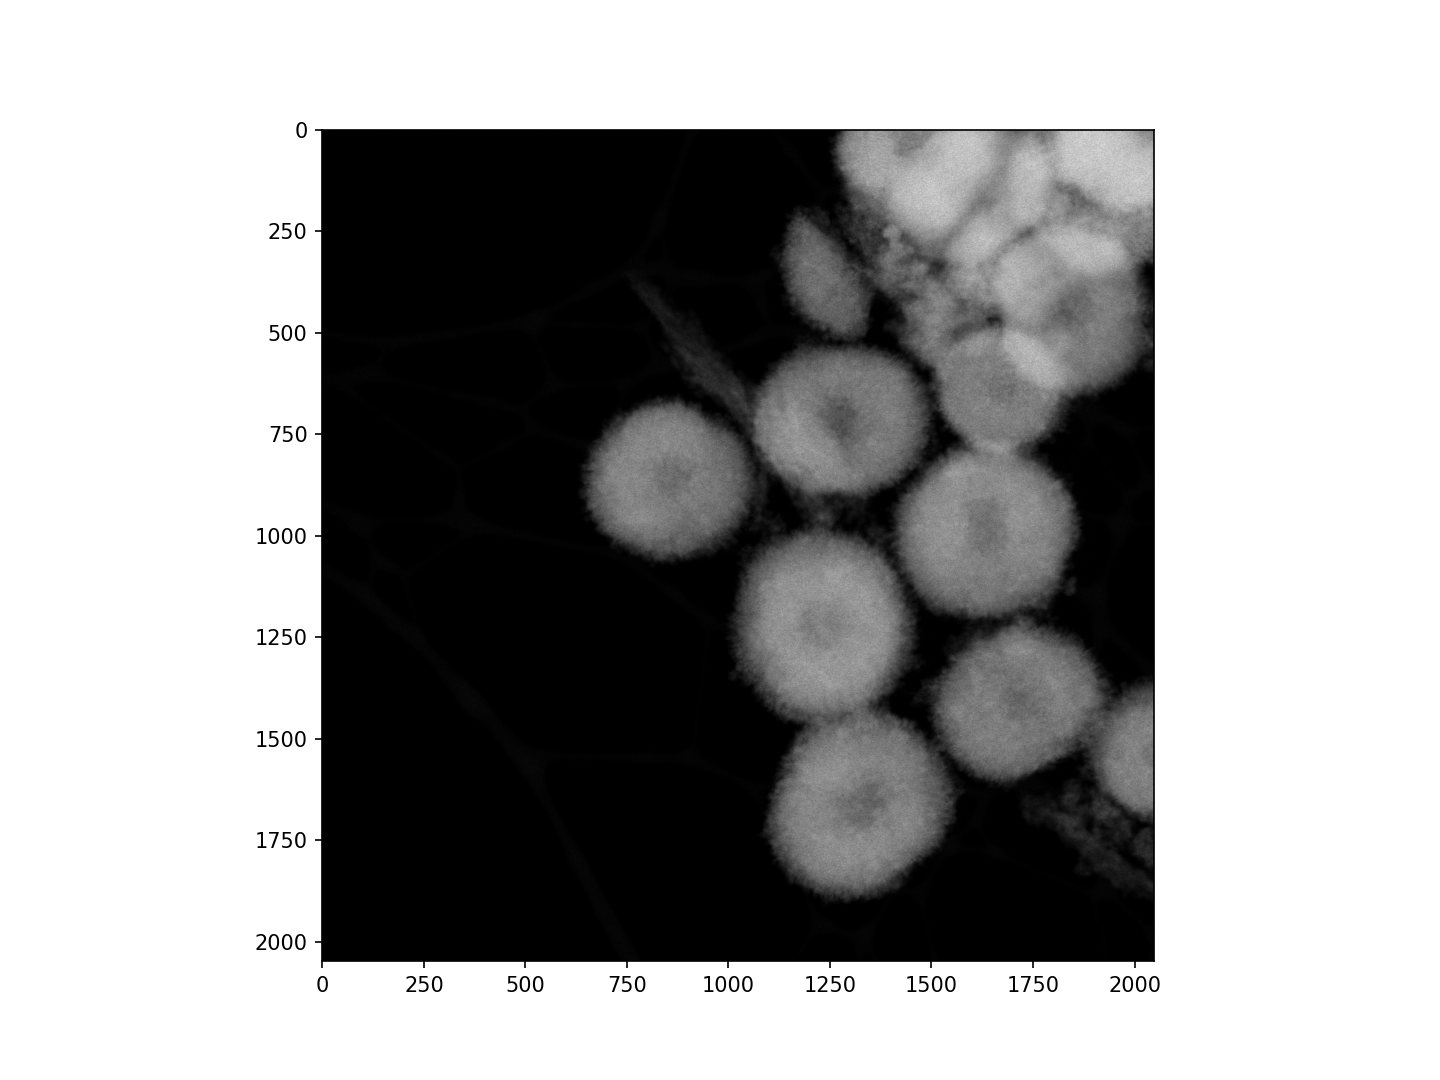

In [9]:
#dPath = Path(r'C:\Users\alexl\Documents\Python\sphere-finder\data')
#fPath = 'CaCO3_HAADF_5.emd'
dPath = Path(r'C:\Users\alexl\Documents\Python\sphere-finder\data')
fPath = 'CaCO3_HAADF_1.emd'

emd1 = nio.emdVelox.fileEMDVelox(dPath / fPath)
#emd1['data']
print(emd1) # print information about the file
im0, metadata0 = emd1.get_dataset(0)
print(metadata0)

fg, ax = plt.subplots(1,1)
ax.imshow(im0, cmap='gray')

## Region-based segmentation

<IPython.core.display.Javascript object>


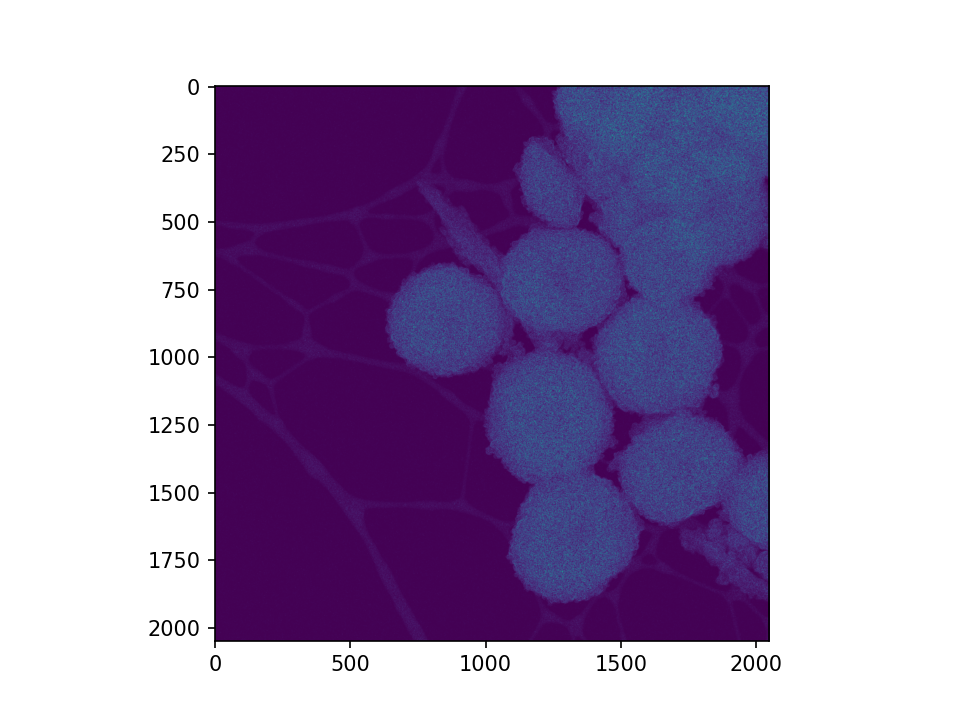

In [10]:
#defining image data variable
im_data = im0

#Sobel gradient of image
elevation_map = sobel(im_data)
fg = plt.figure()
plt.imshow(elevation_map)

<IPython.core.display.Javascript object>


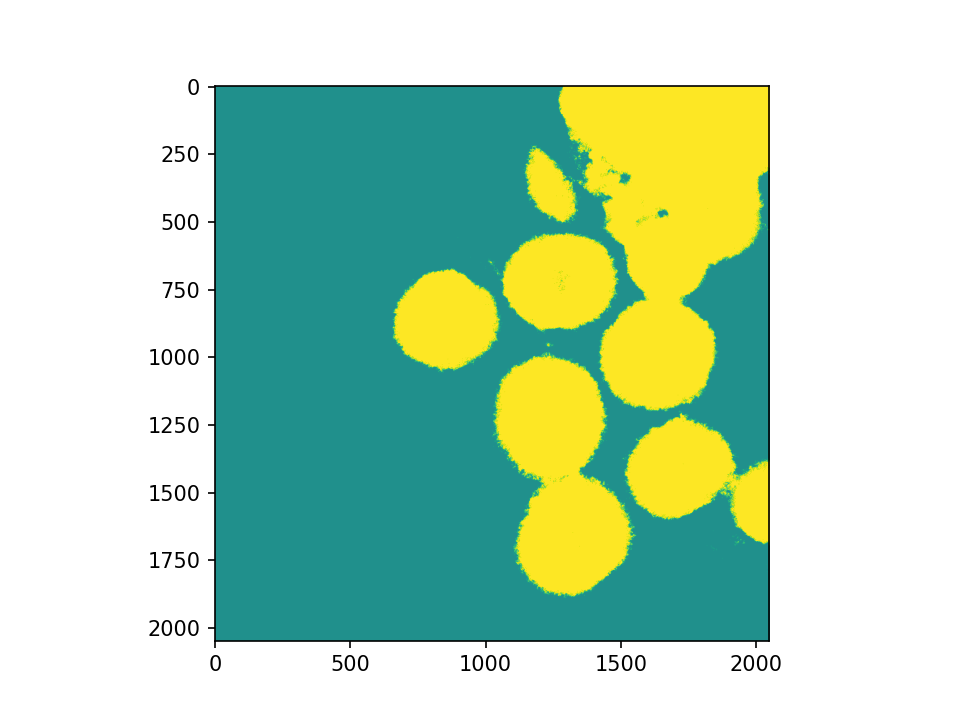

In [11]:
#generate markers (regions from objects) based on threshold value based on Otsu's method
thresh_val = filt.threshold_otsu(im_data)

markers = np.zeros_like(im_data)
markers[im_data < thresh_val] = 1
markers[im_data > thresh_val] = 2


fg = plt.figure()
plt.imshow(markers)

<IPython.core.display.Javascript object>


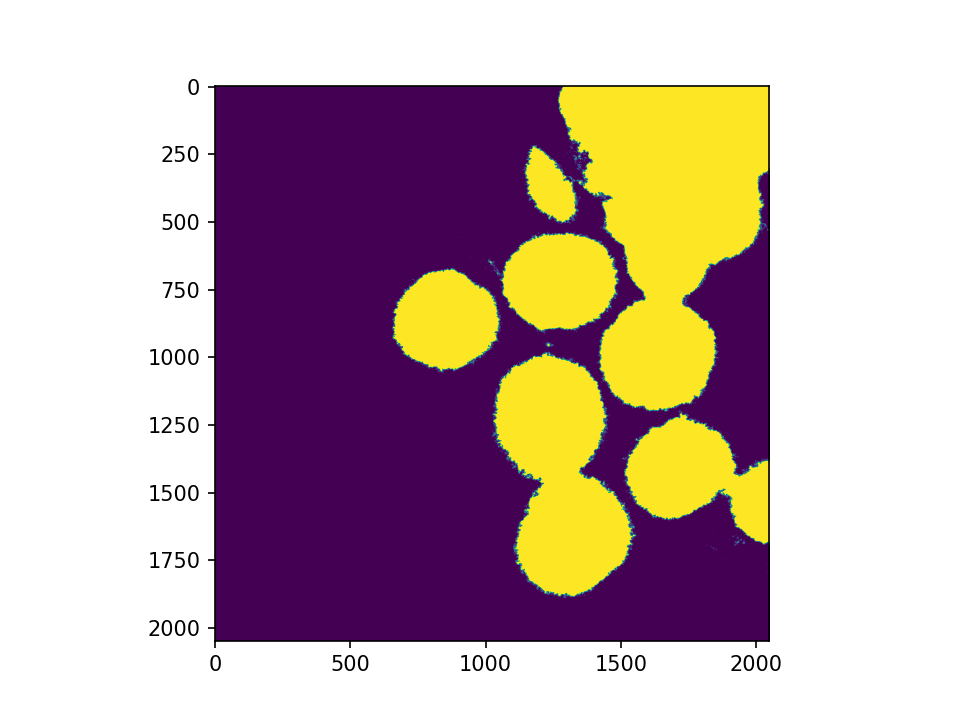

In [12]:
#watershed transform to fill regions of the elevation map starting from the markers
segmentation_image = seg.watershed(elevation_map, markers)
#segmentation_image = seg.watershed(new_mask)
segmentation_image = ndi.binary_fill_holes(segmentation_image - 1)
fg = plt.figure()
plt.imshow(segmentation_image)

## Clean data and and label spheres for quantification

<IPython.core.display.Javascript object>


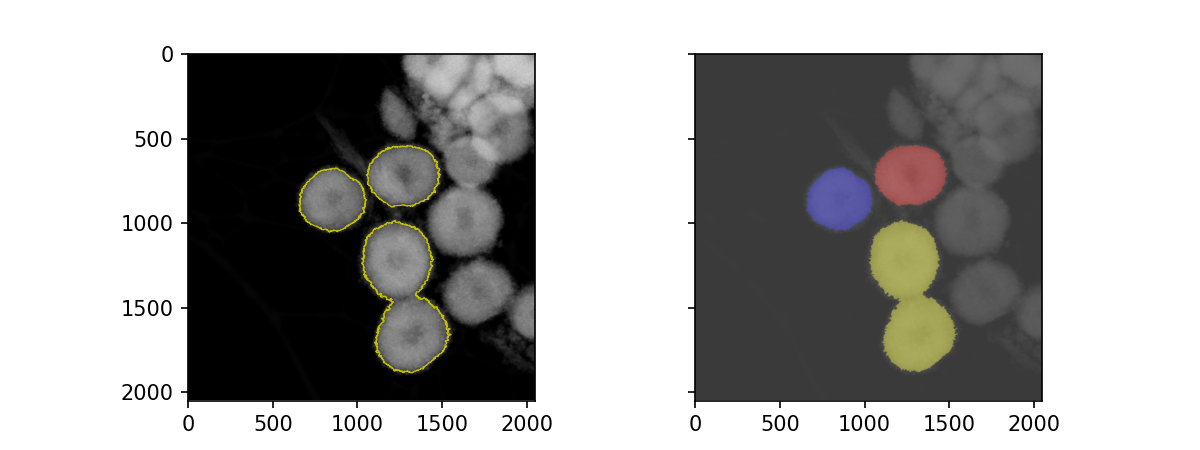

3


In [15]:
#removing small particles and incomplete spheres
cleaned_image0 = morphology.remove_small_objects(segmentation_image, 35000)

#removing objects touching image border
cleaned_image1 = seg.clear_border(cleaned_image0, buffer_size=5)
labeled_spheres, number = ndi.label(cleaned_image1)
image_label_overlay = label2rgb(labeled_spheres, image=im_data, bg_label=0)

fg, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
axes[0].imshow(im_data, cmap=plt.cm.gray)
axes[0].contour(cleaned_image1, [0.5], linewidths=0.5, colors='y')
axes[1].imshow(image_label_overlay)

#display number of spheres in image
print(number)

## Quantify region properties

In [16]:
properties = measure.regionprops_table(labeled_spheres, properties=('area',
                                                                    'major_axis_length',
                                                                    'minor_axis_length',
                                                                    'eccentricity'))
pd.DataFrame(properties)

,area,major_axis_length,minor_axis_length,eccentricity
0,119134,424.173378,358.290832,0.535271
1,108605,386.028918,359.445770,0.364670
2,290049,995.887281,415.524502,0.908796
